# FSD301: Dynamically solving the TSP 

In [192]:
import networkx as nx
import numpy as np
import sys

%matplotlib inline
import matplotlib.pyplot as plt

from itertools import combinations

from reader_students import file_to_graph

## Define Ploting methods

In [193]:
def plot_graph(g):
    fig, ax = plt.subplots(figsize=(25, 6))
    ax.set_axis_off()
    ax.set_aspect(1)
    pos = nx.shell_layout(g)
    labels = nx.get_edge_attributes(g, 'weight')
    # Call nx methods to draw nodes and edges with weight
    nx.draw_networkx_edge_labels(g, pos, edge_labels=labels, ax=ax)
    nx.draw_networkx(g, ax=ax, node_size=800, arrowsize=20, pos=pos)

In [179]:
def norm(x, min, max):
    return (x-min)/(min-max)

def pos_from_points(points):
    pos = dict()
    xmin = min([point.x for point in points])
    xmax = max([point.x for point in points])
    ymin = min([point.y for point in points])
    ymax = max([point.y for point in points])
    # print(f"{xmin=},{xmax=},{ymin=},{ymax=}")
    for index, point in enumerate(points):
        pos[index] = [norm(point.x, xmin, xmax), norm(point.y, ymin, ymax)]
    return pos

def trunc_dict(D):
        for k, v in D.items():
            D[k] = v.__trunc__()
        return D

def plot_cities(g, points):
    fig, ax = plt.subplots(figsize=(30, 20))
    ax.set_axis_off()
    ax.set_aspect(1)
    pos = pos_from_points(points)
    labels = trunc_dict(nx.get_edge_attributes(g, 'weight'))
    # Call nx methods to draw nodes and edges with weight
    nx.draw_networkx_edge_labels(g, pos, edge_labels=labels, ax=ax)
    nx.draw_networkx(g, ax=ax, node_size=600, arrowsize=20, pos=pos)

# Define Held-Karp algorithm

## Found a way to store the key

In [ ]:
def key_by_loop(list, dest):
    return  "".join(str(e) for e in list) + "_" + str(dest)

In [51]:
def create_key(list, destination):
    return(str(sorted(list)).replace('[','').replace(']','')+"_"+str(destination))

In [167]:
def key(list, destination):
    return str(list)+"_"+str(destination)

### Test speed of different way to generate key for L (the dict where we store the length)

In [175]:
%%time
for i in range(100000):
    key_by_loop(tuple(range(10)), i)

CPU times: user 530 ms, sys: 0 ns, total: 530 ms
Wall time: 542 ms


In [176]:
%%time
for i in range(100000):
    create_key(tuple(range(10)), i)

CPU times: user 343 ms, sys: 3.54 ms, total: 346 ms
Wall time: 348 ms


In [177]:
%%time
for i in range(100000):
    key(tuple(range(10)), i)

CPU times: user 260 ms, sys: 0 ns, total: 260 ms
Wall time: 267 ms


In [178]:
%%time
for i in range(10000):
    hash((tuple(range(10)), i))

CPU times: user 98 ms, sys: 0 ns, total: 98 ms
Wall time: 98.9 ms


## Implement the Held Karp algorithm

In [194]:
def held_karp(graph):
    L = {}
    list_node = list(graph.nodes)
    list_node_without1 = list(graph.nodes)
    del list_node_without1[0]
    n = len(list_node)
    print(f"\nCompute TSP with Held-Karp for {n} nodes ...\n")
    
    for i in range(2,n+1):
        key = create_key([list_node[i-1]], list_node[i-1])
        L[key] = graph.edges[list_node[0],list_node[i-1]]["weight"]
        
    for m in range(2,n):
        for S in combinations(list_node_without1,m):
            for j in S:
                u = list()
                list_set = list(S)
                list_set.remove(j)
                for k in list_set:
                    key = create_key(list_set,k)
                    u.append(graph.edges[k,j]["weight"] + L[key])
                key = create_key(list(S),j)
                L[key] = min(u)
    min_path = (min(L[create_key(list_node_without1,j)]+graph.edges[list_node[0],j]["weight"] for j in list_node_without1))
    print(f"\tMininmum tour length found is {min_path.__trunc__()} \n")
    return min_path


### Implement Held Karp Algorithm for nodes with numerical values (starting from 0)

In [196]:
def held_karp_numerical_nodes(graph: nx.Graph):
    # Initialize variables
    n = graph.number_of_nodes()
    print(f"\nCompute TSP with Held-Karp numerical for {n} nodes ...\n")
    initial_node = 0
    list_no_init = tuple(range(1,n))
    L = dict()

    # Initialize L
    for i in list_no_init:
        L[((i,),i)] = graph.edges[initial_node, i]['weight']

    # Loop on the graph
    for m in range(2,n):
        # Print progress
        sys.stdout.write('\r')
        sys.stdout.write("Treating subset of size %d..." % m)
        sys.stdout.flush()
        # Reset L to store only used values, those of size m-1
        Lm_1 = L
        L = dict()
        # Compute values for subset of size m
        for subset in combinations(list_no_init, m):
            for j in subset:
                snoj = list(subset)
                snoj.remove(j)
                snoj = tuple(sorted(snoj))
                L[(subset, j)] = min([
                    Lm_1[(snoj, k)] + graph.edges[k,j]['weight'] for k in snoj
                ])

    # Get back to initial node
    print("\nGetting back to initial node...")
    min_path = min([
        L[(list_no_init, j)] 
        + graph.edges[j, initial_node]['weight'] for j in list_no_init
    ])
    print(f"\n\tMininmum tour length found is {min_path.__trunc__()} \n")

    return min_path


## Read graph data from .txt

In [182]:
# Exemple of parsing pof the .txt file with print
%run data/reader_students.py data/tsp5.txt

expected number of vertices : 5

reading point 0: (20833.3333, 17100.0)
reading point 1: (20900.0, 17066.6667)
reading point 2: (21300.0, 13016.6667)
reading point 3: (21600.0, 14150.0)
reading point 4: (21600.0, 14966.6667)

number of vertices: 5


<Figure size 432x288 with 0 Axes>

In [183]:
?file_to_graph

Signature: file_to_graph(filename)
Docstring:
"Read and parse a .txt file and return a nx.Graph generated from the data

Args:
    filename (str): The path to the .txt file containing the data on the cities

Returns:
    (nx.Graph, Points[]): The graph generated from the .txt file, The list of points found in the .txt file
File:      /mnt/storage/Documents/ISAE/3A/SDD/optim_graph/tp_held_karp/reader_students.py
Type:      function


## Class example


Compute TSP with Held-Karp for 4 nodes ...

	Mininmum tour length found is 13 



13

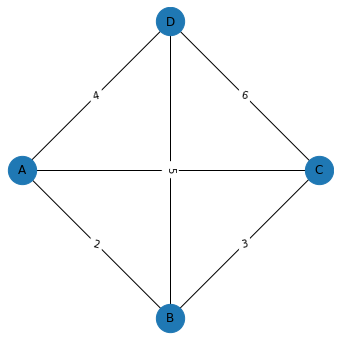

In [184]:
g = nx.Graph()
g.add_weighted_edges_from(
    zip(['A', 'A', 'A', 'B', 'B', 'C'],
        ['B', 'C', 'D', 'C', 'D', 'D'], 
        [2,1,4,3,5,6]),
)
plot_graph(g)
held_karp(g)

# Test on the tspXX.txt files examples

## With 5 cities


Extracting graph from ./data/tsp5.txt ...
Found: 5 points
Points: 
[Point(20833.3,17100.0), Point(20900.0,17066.7), Point(21300.0,13016.7), Point(21600.0,14150.0), Point(21600.0,14966.7)]



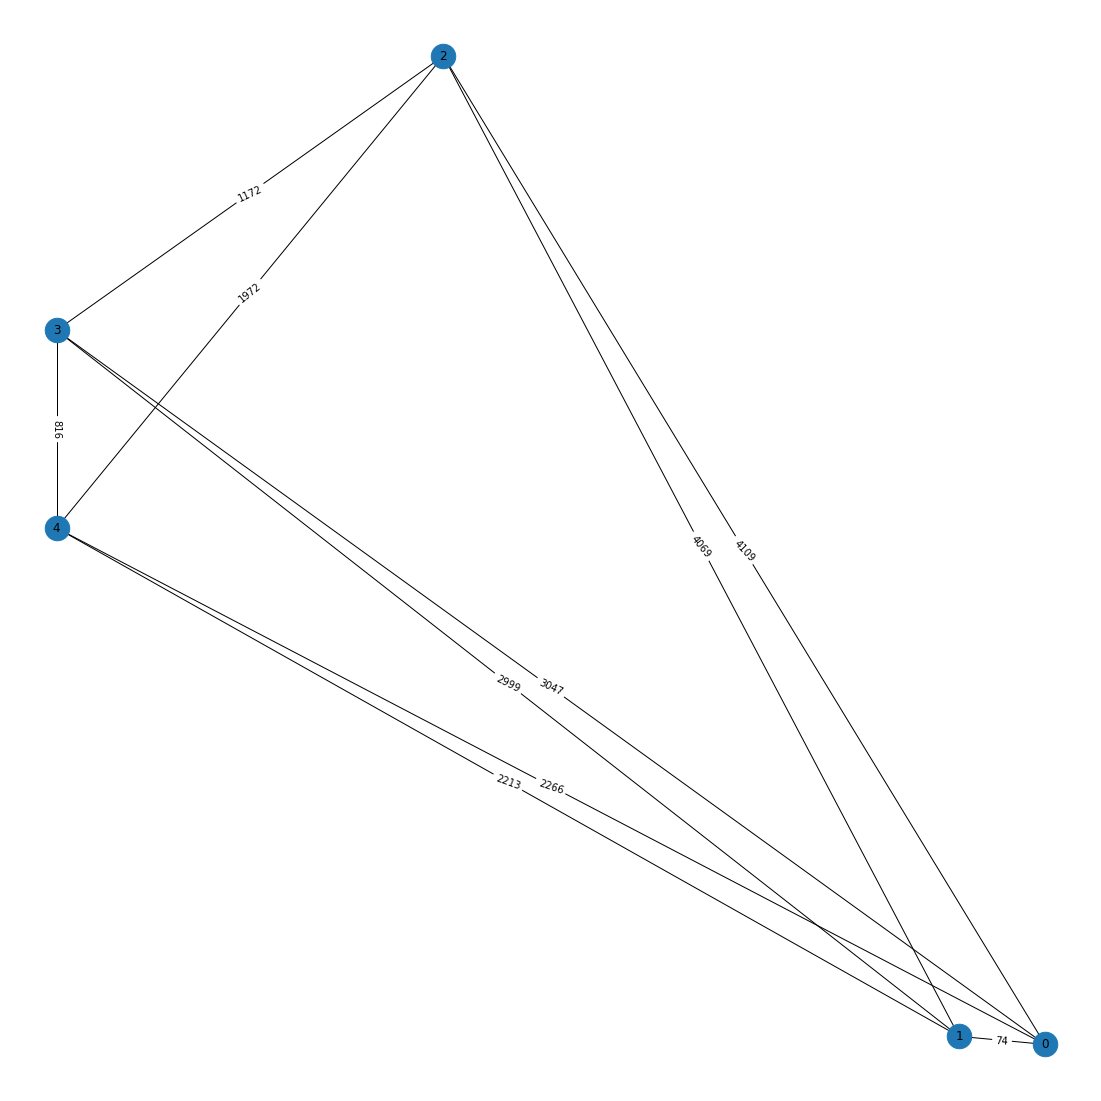

In [185]:
(graph5, points5) = file_to_graph("./data/tsp5.txt")
plot_cities(graph5, points5)

In [186]:
%%time
held_karp(graph5)


Compute TSP with Held-Karp for 5 nodes ...

	Mininmum tour length found is 8387 

CPU times: user 420 µs, sys: 14 µs, total: 434 µs
Wall time: 397 µs


8387.077130278542

## With 10 cities


Extracting graph from ./data/tsp10.txt ...
Found: 10 points
Points: 
[Point(20833.3,17100.0), Point(20900.0,17066.7), Point(21300.0,13016.7), Point(21600.0,14150.0), Point(21600.0,14966.7), Point(21600.0,16500.0), Point(22183.3,13133.3), Point(22583.3,14300.0), Point(22683.3,12716.7), Point(23616.7,15866.7)]



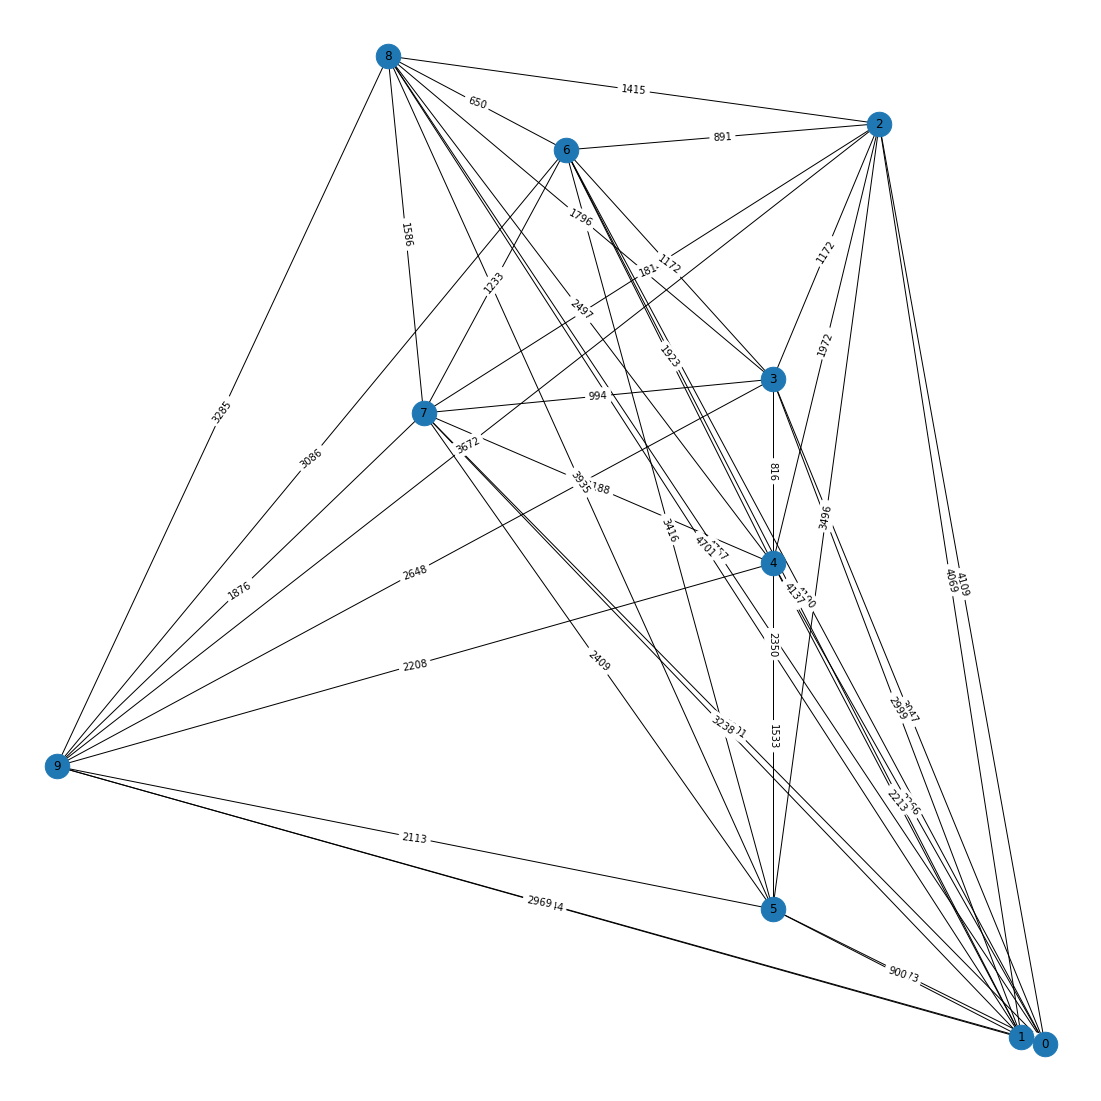

In [188]:
(graph10, points10) = file_to_graph("./data/tsp10.txt")
plot_cities(graph10, points10)

In [189]:
%%time
held_karp(graph10)


Compute TSP with Held-Karp for 10 nodes ...

	Mininmum tour length found is 12349 

CPU times: user 58.3 ms, sys: 63 µs, total: 58.4 ms
Wall time: 69.4 ms


12349.980743996226

### With 15 cities


Extracting graph from ./data/tsp15.txt ...
Found: 15 points
Points: 
[Point(20833.3,17100.0), Point(20900.0,17066.7), Point(21300.0,13016.7), Point(21600.0,14150.0), Point(21600.0,14966.7), Point(21600.0,16500.0), Point(22183.3,13133.3), Point(22583.3,14300.0), Point(22683.3,12716.7), Point(23616.7,15866.7), Point(23700.0,15933.3), Point(23883.3,14533.3), Point(24166.7,13250.0), Point(25149.2,12365.8), Point(26133.3,14500.0)]



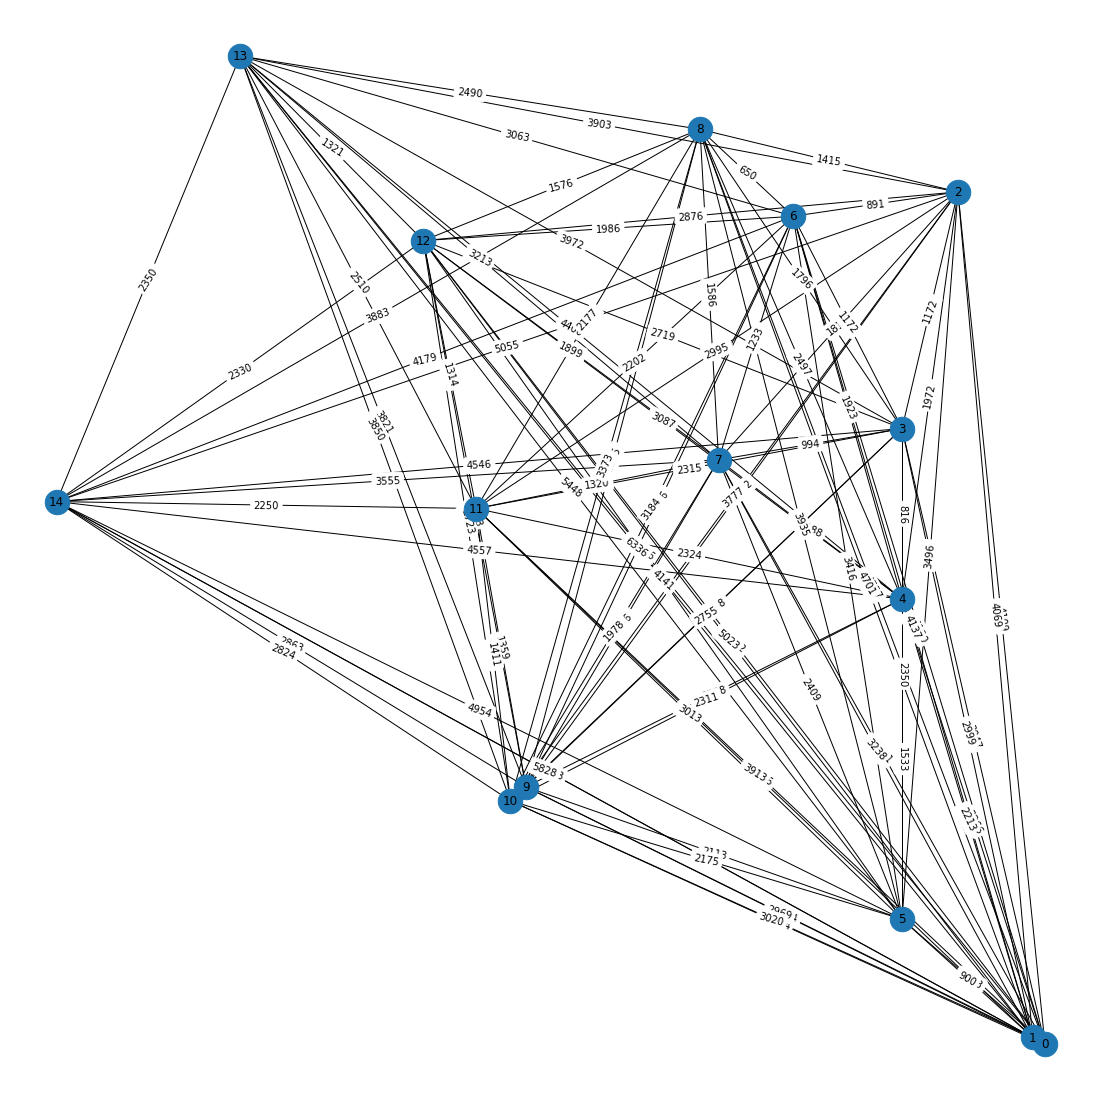

In [106]:
(graph15, points15) = file_to_graph("./data/tsp15.txt")
plot_cities(graph15, points15)

In [108]:
%%time
held_karp(graph15)


Compute TSP with Held-Karp for 15 nodes ...

	Mininmum tour length found is 19269 

CPU times: user 3.07 s, sys: 5.56 ms, total: 3.07 s
Wall time: 3.09 s


19269.93599779425

In [162]:
%%time
held_karp_numerical_nodes(graph15)


Compute TSP with Held-Karp numerical for 15 nodes ...

Treating subset of size 14...
Getting back to initial node...

	Mininmum tour length found is 19269 

CPU times: user 1.31 s, sys: 7.86 ms, total: 1.32 s
Wall time: 1.32 s


19269.93599779425

### With 20 cities


Extracting graph from ./data/tsp20.txt ...
Found: 20 points
Points: 
[Point(20833.3,17100.0), Point(20900.0,17066.7), Point(21300.0,13016.7), Point(21600.0,14150.0), Point(21600.0,14966.7), Point(21600.0,16500.0), Point(22183.3,13133.3), Point(22583.3,14300.0), Point(22683.3,12716.7), Point(23616.7,15866.7), Point(23700.0,15933.3), Point(23883.3,14533.3), Point(24166.7,13250.0), Point(25149.2,12365.8), Point(26133.3,14500.0), Point(26150.0,10550.0), Point(26283.3,12766.7), Point(26433.3,13433.3), Point(26550.0,13850.0), Point(26733.3,11683.3)]



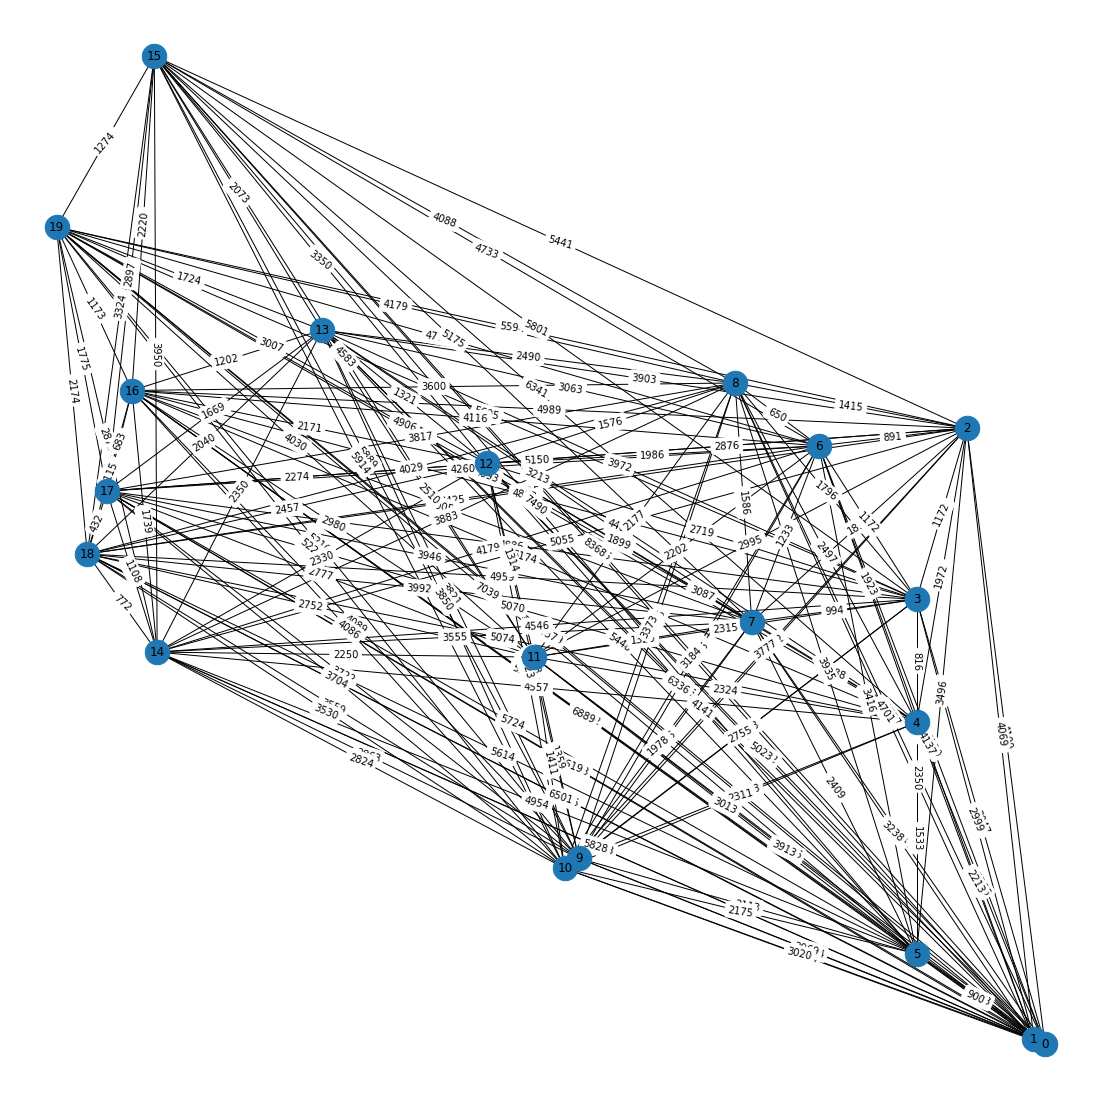

In [191]:
(graph20, points20) = file_to_graph("./data/tsp20.txt")
plot_cities(graph20, points20)

In [163]:
%%time
held_karp_numerical_nodes(graph20)


Compute TSP with Held-Karp numerical for 20 nodes ...

Treating subset of size 19...
Getting back to initial node...

	Mininmum tour length found is 23328 

CPU times: user 1min 25s, sys: 590 ms, total: 1min 26s
Wall time: 1min 26s


23328.990366914215

### With 25 cities


Extracting graph from ./data/tsp25.txt ...
Found: 25 points
Points: 
[Point(20833.3,17100.0), Point(20900.0,17066.7), Point(21300.0,13016.7), Point(21600.0,14150.0), Point(21600.0,14966.7), Point(21600.0,16500.0), Point(22183.3,13133.3), Point(22583.3,14300.0), Point(22683.3,12716.7), Point(23616.7,15866.7), Point(23700.0,15933.3), Point(23883.3,14533.3), Point(24166.7,13250.0), Point(25149.2,12365.8), Point(26133.3,14500.0), Point(26150.0,10550.0), Point(26283.3,12766.7), Point(26433.3,13433.3), Point(26550.0,13850.0), Point(26733.3,11683.3), Point(27026.1,13051.9), Point(27096.1,13415.8), Point(27153.6,13203.3), Point(27166.7,9833.3), Point(27233.3,10450.0)]



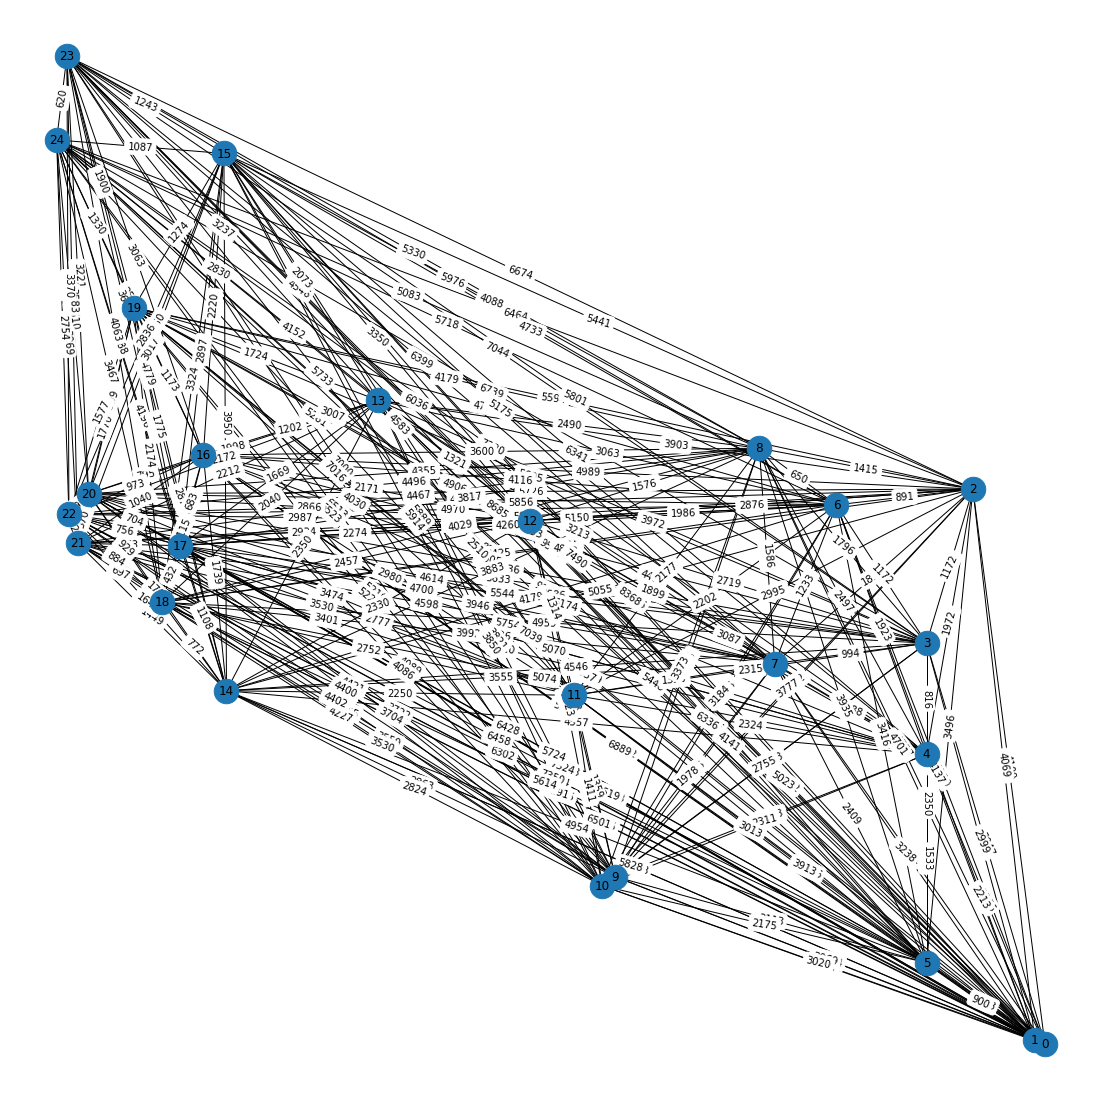

In [164]:
(graph25, points25) = file_to_graph("./data/tsp25.txt")
plot_cities(graph25, points25)

In [195]:
%%time
held_karp_numerical_nodes(graph25)


Compute TSP with Held-Karp numerical for 25 nodes ...

Treating subset of size 24...
Getting back to initial node...

	Mininmum tour length found is 26442 

CPU times: user 1h 22min 14s, sys: 1min 48s, total: 1h 24min 3s
Wall time: 1h 30min 33s


26442.73030895475